Cryptocurrency trading bot.

Hardcoded parameters.

In [1]:
traded_symbol = 'ZRXBTC'
symbols = {'ZRXBTC': None, 
           'ZRXUSDT': None, 
           'BTCUSDT': None}
percentage_to_trade = 0.9999
interval = '1m'
window_1 = 1
window_2 = 1
period = '12 hours ago UTC'
api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)
You should consider upgrading via the '/home/samuel/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/samuel/anaconda3/bin/python -m pip install --upgrade pip' command.


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None # This avoids SettingWithCopyWarnings

Function definitions.

In [4]:
def calculate_moving_average(dataset, window=2, method='simple'):
    if method == 'simple':
        dataset = dataset.rolling(window=window)
    elif method == 'exponential':
        dataset = dataset.ewm(span=window)

    dataset = dataset.mean()
    dataset = dataset.fillna(method='backfill', axis='index')
    return dataset

def calculate_renko(dataset, brick_size=1):
    renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
    renko_.index.name = 'date'
    renko_ = Renko(renko_.reset_index())
    renko_.brick_size = brick_size
    renko_ = renko_.get_ohlc_data().set_index('date')
    renko_.index.name = 'time'
    return renko_.uptrend

def calculate_heikin_ashi(df):
    df = df.tz_localize(tz=None, ambiguous='infer')
    df = df[['open', 'high', 'low', 'close']].copy().astype('float')
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

    return heikin_ashi_df

def calculate_RSI(ticker, span=14):
    up = ticker['close'].astype(float).pct_change()
    down = up.copy()
    up[up < 0.0] = 0.0
    down[down > 0.0] = 0.0

    up = up.ewm(span=span).mean().fillna(method='pad')
    down = down.ewm(span=span).mean().abs().fillna(method='pad')

    ticker = up / down
    ticker = 100 - (100 / (1 + ticker))

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = ticker.iloc[1]
    return ticker.fillna(method='pad')

def calculate_MACD(ticker, span1=12, span2=26, average='exponential'):
    if average == 'linear':
        shorter = ticker['close'].rolling(window=span1).mean()
        longer = ticker['close'].rolling(window=span2).mean()
    if average == 'exponential':
        shorter = ticker['close'].ewm(span=span1).mean()
        longer = ticker['close'].ewm(span=span2).mean()

    ticker = shorter - longer

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = 0.0
    ticker = ticker.fillna(method='pad').to_frame(name='MACD')
    ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
    ticker['histogram'] = ticker.MACD - ticker.signal_line
    return ticker

def calculate_ATR(ticker, min_periods=14):
    ticker = ticker.astype(float)
    up = pd.DataFrame([ticker['high'].shift(), 
                       ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

    down = pd.DataFrame([ticker['low'].shift(), 
                         ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

    ticker = (up - down).ewm(alpha=1 / min_periods, 
                             min_periods=min_periods, 
                             adjust=False).mean()

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    return ticker.fillna(method='backfill')

def calculate_bollinger_bands(dataframe, period=20):
    df = dataframe.copy()
    df['MA'] = df['close'].rolling(period).mean()
    df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
    df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
    df['BB_width'] = df['BB_up'] - df['BB_down']
    df.dropna(inplace=True)
    return df

def calculate_average_directional_index(df, n, n_ADX):
    dataset_index = df.index.copy()
    df = df.reset_index().drop(columns=['time']).astype(float)
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(), name='ADX')
    df = df.join(ADX)
    df.index = dataset_index
    return df.ADX.dropna()

def calculate_commodity_channel_index(dataset, min_periods=20):
    PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
    CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                    PP.rolling(min_periods, min_periods=min_periods).std(),
                    name='CCI')
    dataset = dataset.join(CCI)
    return dataset['CCI']

def calculate_KDJ(dataset):
    def get_rsv(dataset):
        low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
        high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
        return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

    def calc_kd(column):
        k = 50.0
        for i in (1.0 / 3.0) * column:
            k = (2.0 / 3.0) * k + i
            yield k

    dataset['K'] = list(calc_kd(get_rsv(dataset)))
    dataset['D'] = list(calc_kd(dataset['K']))
    dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
    return dataset[['K', 'D', 'J']]

def download_dataset(symbol=traded_symbol, interval=interval):
    dataset_downloaded = \
        client.get_historical_klines(symbol=symbol, 
                                     interval=interval, 
                                     start_str=period)

    dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                      columns=['time', 
                                               'open', 
                                               'high', 
                                               'low', 
                                               'close', 
                                               'volume', 
                                               'Close time', 
                                               'Quote asset volume', 
                                               'Number of trades', 
                                               'Taker buy base asset volume', 
                                               'Taker buy quote asset volume', 
                                               'Ignore'])

    four_hours = 14400
    milliseconds = 1000

    dataset_downloaded['time'] = \
        dataset_downloaded['time'].apply(lambda timestamp: \
                                         datetime.datetime.fromtimestamp((timestamp / \
                                                                          milliseconds) - \
                                                                         four_hours))

    dataset_downloaded = dataset_downloaded[['time', 
                                             'open', 
                                             'high', 
                                             'low', 
                                             'close', 
                                             'volume']]

    dataset_downloaded.set_index('time', inplace=True)
    dataset_downloaded = dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))
    return dataset_downloaded

class Cryptocurrency:
    def __init__(self, client, symbol, interval=interval):
        symbol_info = client.get_symbol_info(symbol)
        self.symbol = symbol
        self.interval = interval
        self.base_asset = symbol_info['baseAsset']
        self.quote_asset = symbol_info['quoteAsset']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'PRICE_FILTER'][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'LOT_SIZE'][0]
        self.base_asset_precision = client.get_symbol_info(symbol)['baseAssetPrecision']
        self.quote_asset_precision = client.get_symbol_info(symbol)['quotePrecision']
        self.dataset = download_dataset(symbol=symbol, interval=interval)
        self.calculate_indicators()
        self.calculate_balance()
        self.calculate_position()
        self.state = 'entry'

    def calculate_position(self):
        if self.base_asset_buy_balance > self.base_asset_sell_balance:
            self.position = 'sell'
        elif self.base_asset_sell_balance > self.base_asset_buy_balance:
            self.position = 'buy'

    def calculate_balance(self):
        self.quote_asset_buy_balance = float(client.get_asset_balance(asset=self.quote_asset)['free'])
        self.base_asset_buy_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.base_asset_buy_balance = self.quote_asset_buy_balance / self.base_asset_buy_last_price
        self.base_asset_sell_balance = float(client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_sell_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.quote_asset_sell_balance = self.base_asset_sell_balance * self.quote_asset_sell_last_price
        self.quote_asset_balance_combined = self.quote_asset_sell_balance + self.quote_asset_buy_balance
        self.base_asset_balance_combined = self.base_asset_buy_balance + self.base_asset_sell_balance

    def calculate_indicators(self):
        dataset = self.dataset.astype(float)
        self.dataset_10m = self.dataset.copy().astype(float)
        self.dataset_10m = self.dataset_10m.resample('10T')
        self.dataset_10m = self.dataset_10m.agg({'open': 'first', 
                                                 'high': 'max', 
                                                 'low': 'min', 
                                                 'close': 'last', 
                                                 'volume': 'sum'})
        self.heikin_ashi = calculate_moving_average(dataset, window=window_1, method='simple')
        self.heikin_ashi = calculate_heikin_ashi(self.heikin_ashi)
        self.heikin_ashi = calculate_moving_average(dataset, window=window_2, method='exponential')
        self.RSI_6 = calculate_RSI(dataset, span=6)
        self.RSI_12 = calculate_RSI(dataset, span=12)
        self.CCI = calculate_commodity_channel_index(self.heikin_ashi, min_periods=20)
        self.brick_size = calculate_ATR(dataset, min_periods=14).median()
        self.renko = calculate_renko(dataset, brick_size=self.brick_size)
        self.ADX = calculate_average_directional_index(dataset, n=14, n_ADX=14)
        self.KDJ = calculate_KDJ(dataset)
        self.MACD = calculate_MACD(dataset)
        self.bollinger_bands = calculate_bollinger_bands(dataset, period=20)
        self.trend_trigger = (self.heikin_ashi['close'] - self.heikin_ashi['open']) > 0
        self.overtraded_trigger = self.RSI_6 > self.RSI_12
        self.trend_strength_trigger = self.ADX > 0.25
        self.momentum_trigger = self.KDJ['J'] > self.KDJ['D']
        self.volatility_trigger = (self.bollinger_bands['BB_width'] / dataset['close']) > 0.0005
        self.MACD_trigger = self.MACD['histogram'] > 0
        self.real_trigger = (dataset['close'] - dataset['open']) > 0

        self.heikin_ashi_10m = calculate_moving_average(self.dataset_10m, window=window_1, method='simple')
        self.heikin_ashi_10m = calculate_heikin_ashi(self.heikin_ashi_10m)
        self.heikin_ashi_10m = calculate_moving_average(self.dataset_10m, window=window_2, method='exponential')
        self.ADX_10m = calculate_average_directional_index(self.dataset_10m, n=14, n_ADX=14)
        self.KDJ_10m = calculate_KDJ(self.dataset_10m)
        self.MACD_10m = calculate_MACD(self.dataset_10m)
        self.bollinger_bands_10m = calculate_bollinger_bands(self.dataset_10m, period=20)
        self.trend_trigger_10m = (self.heikin_ashi_10m['close'] - self.heikin_ashi_10m['open']) > 0
        self.trend_strength_trigger_10m = self.ADX_10m > 0.25
        self.momentum_trigger_10m = self.KDJ_10m['J'] > self.KDJ_10m['D']
        self.volatility_trigger_10m = (self.bollinger_bands_10m['BB_width'] / self.dataset_10m['close']) > 0.0005
        self.MACD_trigger_10m = self.MACD_10m['histogram'] > 0
        self.real_trigger_10m = (self.dataset_10m['close'] - self.dataset_10m['open']) > 0

    def print_balance(self):
        print('quote_asset_buy_balance: ', self.quote_asset_buy_balance)
        print('base_asset_buy_last_price: ', self.base_asset_buy_last_price)
        print('base_asset_buy_balance: ', self.base_asset_buy_balance)
        print('base_asset_sell_balance: ', self.base_asset_sell_balance)
        print('quote_asset_sell_last_price: ', self.quote_asset_sell_last_price)
        print('quote_asset_sell_balance: ', self.quote_asset_sell_balance)
        print('quote_asset_balance_combined: ', self.quote_asset_balance_combined)
        print('base_asset_balance_combined: ', self.base_asset_balance_combined)

    def trade(self):
        self.calculate_balance()

        if self.position == 'sell':
            coins_available = self.base_asset_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.base_asset_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.step_size) / float(10**self.step_size)

        if self.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.tick_size)) / float(abs(self.tick_size))

        client.create_order(symbol=self.symbol, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position

In [5]:
client = Client(api_key, api_secret)

In [6]:
for symbol in symbols.keys():
    symbols[symbol] = Cryptocurrency(client, symbol, interval)
    print(symbols[symbol].dataset)

                           open        high         low       close volume
time                                                                      
2020-05-15 03:58:00  0.00004175  0.00004179  0.00004172  0.00004172   7397
2020-05-15 03:59:00  0.00004169  0.00004173  0.00004166  0.00004172   7499
2020-05-15 04:00:00  0.00004172  0.00004195  0.00004172   0.0000419  70327
2020-05-15 04:01:00   0.0000419  0.00004203  0.00004183  0.00004194  26156
2020-05-15 04:02:00  0.00004193  0.00004198  0.00004183  0.00004192  12011
...                         ...         ...         ...         ...    ...
2020-05-15 15:53:00  0.00004086    0.000041  0.00004086    0.000041  12134
2020-05-15 15:54:00    0.000041  0.00004118  0.00004091  0.00004116  33416
2020-05-15 15:55:00  0.00004118  0.00004118  0.00004115  0.00004118   6106
2020-05-15 15:56:00  0.00004118  0.00004129  0.00004118  0.00004125  24331
2020-05-15 15:57:00  0.00004123  0.00004124  0.00004106   0.0000412  34441

[720 rows x 5 columns]
 

In [7]:
for symbol in symbols.keys():
    print(symbol)
    print(symbols[symbol].heikin_ashi)
    fig = go.Figure(data=[go.Candlestick(x=symbols[symbol].heikin_ashi.index.to_series(), 
                                         open=symbols[symbol].heikin_ashi['open'], 
                                         high=symbols[symbol].heikin_ashi['high'], 
                                         low=symbols[symbol].heikin_ashi['low'], 
                                         close=symbols[symbol].heikin_ashi['close'])])

    fig.show()

ZRXBTC
                         open      high       low     close   volume
time                                                                
2020-05-15 03:58:00  0.000042  0.000042  0.000042  0.000042   7397.0
2020-05-15 03:59:00  0.000042  0.000042  0.000042  0.000042   7499.0
2020-05-15 04:00:00  0.000042  0.000042  0.000042  0.000042  70327.0
2020-05-15 04:01:00  0.000042  0.000042  0.000042  0.000042  26156.0
2020-05-15 04:02:00  0.000042  0.000042  0.000042  0.000042  12011.0
...                       ...       ...       ...       ...      ...
2020-05-15 15:53:00  0.000041  0.000041  0.000041  0.000041  12134.0
2020-05-15 15:54:00  0.000041  0.000041  0.000041  0.000041  33416.0
2020-05-15 15:55:00  0.000041  0.000041  0.000041  0.000041   6106.0
2020-05-15 15:56:00  0.000041  0.000041  0.000041  0.000041  24331.0
2020-05-15 15:57:00  0.000041  0.000041  0.000041  0.000041  34441.0

[720 rows x 5 columns]


ZRXUSDT
                       open    high     low   close     volume
time                                                          
2020-05-15 03:58:00  0.4006  0.4007  0.4002  0.4002    2594.46
2020-05-15 03:59:00  0.4003  0.4004  0.4000  0.4002   12276.33
2020-05-15 04:00:00  0.4002  0.4010  0.4001  0.4002   41369.80
2020-05-15 04:01:00  0.4002  0.4010  0.4002  0.4010   41291.65
2020-05-15 04:02:00  0.4010  0.4010  0.4000  0.4000  166996.97
...                     ...     ...     ...     ...        ...
2020-05-15 15:53:00  0.3796  0.3808  0.3795  0.3808   13508.75
2020-05-15 15:54:00  0.3808  0.3822  0.3808  0.3815   19678.65
2020-05-15 15:55:00  0.3820  0.3823  0.3817  0.3818    4363.10
2020-05-15 15:56:00  0.3822  0.3826  0.3817  0.3817    8034.83
2020-05-15 15:57:00  0.3822  0.3829  0.3811  0.3821   60708.25

[720 rows x 5 columns]


BTCUSDT
                        open     high      low    close      volume
time                                                               
2020-05-15 03:59:00  9597.47  9599.00  9590.00  9592.38   44.530911
2020-05-15 04:00:00  9593.53  9593.53  9562.86  9567.98  156.503486
2020-05-15 04:01:00  9566.00  9580.00  9563.76  9579.00   82.367172
2020-05-15 04:02:00  9579.34  9579.94  9541.08  9545.08  277.601090
2020-05-15 04:03:00  9545.42  9564.57  9545.22  9559.96  102.099744
...                      ...      ...      ...      ...         ...
2020-05-15 15:54:00  9295.05  9297.95  9288.73  9293.84   15.462854
2020-05-15 15:55:00  9294.25  9300.00  9280.51  9281.53   77.482287
2020-05-15 15:56:00  9281.52  9281.52  9267.11  9270.44   63.917749
2020-05-15 15:57:00  9270.02  9300.00  9268.72  9297.44   48.405406
2020-05-15 15:58:00  9298.52  9302.00  9295.86  9301.90   16.053698

[720 rows x 5 columns]


time
2020-05-15 03:58:00         NaN
2020-05-15 03:59:00         NaN
2020-05-15 04:00:00         NaN
2020-05-15 04:01:00         NaN
2020-05-15 04:02:00         NaN
                         ...   
2020-05-15 15:53:00   -0.539181
2020-05-15 15:54:00    0.243551
2020-05-15 15:55:00    0.736675
2020-05-15 15:56:00    1.044819
2020-05-15 15:57:00    0.557043
Name: CCI, Length: 720, dtype: float64


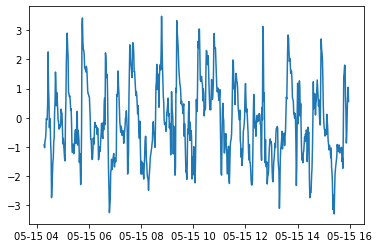

time
2020-05-15 03:58:00         NaN
2020-05-15 03:59:00         NaN
2020-05-15 04:00:00         NaN
2020-05-15 04:01:00         NaN
2020-05-15 04:02:00         NaN
                         ...   
2020-05-15 15:53:00   -1.528335
2020-05-15 15:54:00   -0.783938
2020-05-15 15:55:00   -0.435305
2020-05-15 15:56:00   -0.326131
2020-05-15 15:57:00   -0.251838
Name: CCI, Length: 720, dtype: float64


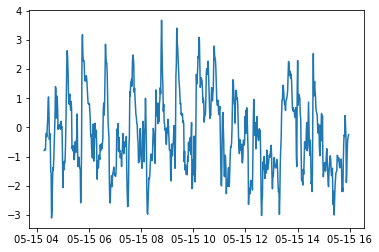

time
2020-05-15 03:59:00         NaN
2020-05-15 04:00:00         NaN
2020-05-15 04:01:00         NaN
2020-05-15 04:02:00         NaN
2020-05-15 04:03:00         NaN
                         ...   
2020-05-15 15:54:00   -0.864663
2020-05-15 15:55:00   -0.945146
2020-05-15 15:56:00   -1.253161
2020-05-15 15:57:00   -0.711128
2020-05-15 15:58:00   -0.271976
Name: CCI, Length: 720, dtype: float64


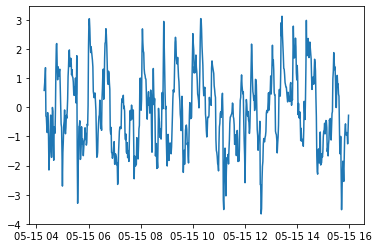

In [8]:
for symbol in symbols.keys():
    print(symbols[symbol].CCI)
    plt.plot(symbols[symbol].CCI)
    plt.show()

time
2020-05-15 03:58:00     True
2020-05-15 04:00:00     True
2020-05-15 04:05:00    False
2020-05-15 04:05:00    False
2020-05-15 04:05:00    False
                       ...  
2020-05-15 15:24:00    False
2020-05-15 15:24:00    False
2020-05-15 15:36:00    False
2020-05-15 15:48:00     True
2020-05-15 15:52:00    False
Name: uptrend, Length: 119, dtype: bool


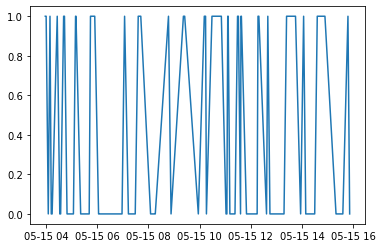

time
2020-05-15 03:58:00     True
2020-05-15 04:05:00    False
2020-05-15 04:05:00    False
2020-05-15 04:05:00    False
2020-05-15 04:06:00    False
                       ...  
2020-05-15 15:24:00    False
2020-05-15 15:36:00    False
2020-05-15 15:41:00    False
2020-05-15 15:42:00    False
2020-05-15 15:52:00    False
Name: uptrend, Length: 125, dtype: bool


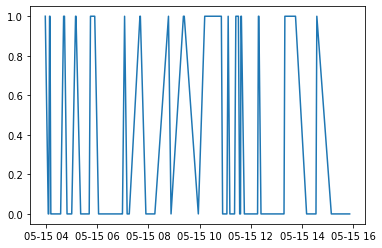

time
2020-05-15 03:59:00     True
2020-05-15 04:15:00    False
2020-05-15 04:29:00    False
2020-05-15 04:50:00     True
2020-05-15 04:59:00    False
                       ...  
2020-05-15 15:47:00    False
2020-05-15 15:47:00    False
2020-05-15 15:49:00     True
2020-05-15 15:51:00     True
2020-05-15 15:56:00    False
Name: uptrend, Length: 90, dtype: bool


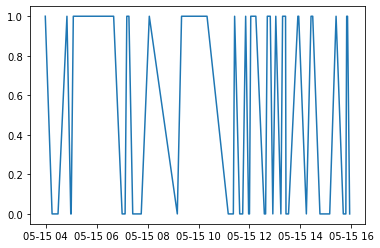

In [9]:
for symbol in symbols.keys():
    print(symbols[symbol].renko)
    plt.plot(symbols[symbol].renko)
    plt.show()

time
2020-05-15 04:24:00    0.105039
2020-05-15 04:25:00    0.182517
2020-05-15 04:26:00    0.247156
2020-05-15 04:27:00    0.283526
2020-05-15 04:28:00    0.289228
                         ...   
2020-05-15 15:53:00    0.343566
2020-05-15 15:54:00    0.316005
2020-05-15 15:55:00    0.278255
2020-05-15 15:56:00    0.258558
2020-05-15 15:57:00    0.258558
Name: ADX, Length: 694, dtype: float64


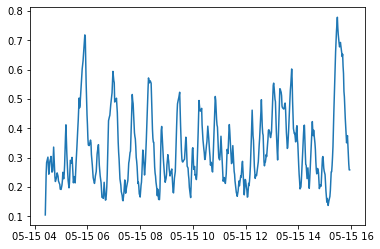

time
2020-05-15 04:24:00    0.192341
2020-05-15 04:25:00    0.234570
2020-05-15 04:26:00    0.269802
2020-05-15 04:27:00    0.263171
2020-05-15 04:28:00    0.238551
                         ...   
2020-05-15 15:53:00    0.299743
2020-05-15 15:54:00    0.284895
2020-05-15 15:55:00    0.265325
2020-05-15 15:56:00    0.258582
2020-05-15 15:57:00    0.258582
Name: ADX, Length: 694, dtype: float64


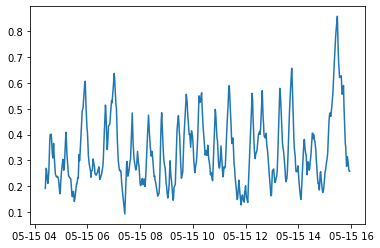

time
2020-05-15 04:25:00    0.308142
2020-05-15 04:26:00    0.318479
2020-05-15 04:27:00    0.343599
2020-05-15 04:28:00    0.386759
2020-05-15 04:29:00    0.423143
                         ...   
2020-05-15 15:54:00    0.594719
2020-05-15 15:55:00    0.608790
2020-05-15 15:56:00    0.573281
2020-05-15 15:57:00    0.537923
2020-05-15 15:58:00    0.537923
Name: ADX, Length: 694, dtype: float64


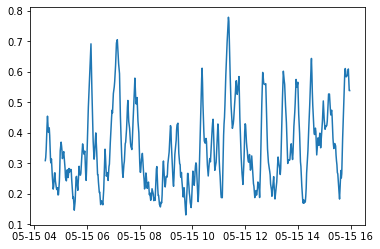

In [10]:
for symbol in symbols.keys():
    print(symbols[symbol].ADX)
    plt.plot(symbols[symbol].ADX)
    plt.show()

                             K          D          J
time                                                
2020-05-15 03:58:00  33.333333  44.444444  11.111111
2020-05-15 03:59:00  37.606838  42.165242  28.490028
2020-05-15 04:00:00  52.657432  45.662639  66.647018
2020-05-15 04:01:00  60.330180  50.551819  79.886901
2020-05-15 04:02:00  63.643543  54.915727  81.099176
...                        ...        ...        ...
2020-05-15 15:53:00  41.556996  51.218367  22.234256
2020-05-15 15:54:00  45.933831  49.456855  38.887783
2020-05-15 15:55:00  49.893387  49.602366  50.475431
2020-05-15 15:56:00  56.918172  52.040968  66.672581
2020-05-15 15:57:00  58.913190  54.331709  68.076153

[720 rows x 3 columns]


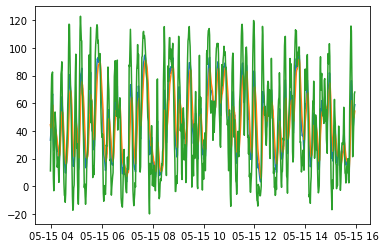

                             K          D          J
time                                                
2020-05-15 03:58:00  33.333333  44.444444  11.111111
2020-05-15 03:59:00  31.746032  40.211640  14.814815
2020-05-15 04:00:00  27.830688  36.084656  11.322751
2020-05-15 04:01:00  51.887125  41.352146  72.957084
2020-05-15 04:02:00  34.591417  39.098569  25.577112
...                        ...        ...        ...
2020-05-15 15:53:00  41.044973  50.689744  21.755432
2020-05-15 15:54:00  42.009780  47.796423  30.436495
2020-05-15 15:55:00  44.168136  46.586994  39.330421
2020-05-15 15:56:00  45.101990  46.091993  43.121984
2020-05-15 15:57:00  47.744761  46.642915  49.948452

[720 rows x 3 columns]


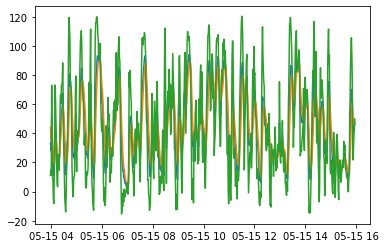

                             K          D          J
time                                                
2020-05-15 03:59:00  42.148148  47.382716  31.679012
2020-05-15 04:00:00  32.821141  42.528858  13.405708
2020-05-15 04:01:00  36.767313  40.608343  29.085254
2020-05-15 04:02:00  26.813568  36.010085   8.420535
2020-05-15 04:03:00  28.741274  33.587148  19.049526
...                        ...        ...        ...
2020-05-15 15:54:00  67.514008  59.797500  82.947025
2020-05-15 15:55:00  64.124525  61.239842  69.893891
2020-05-15 15:56:00  52.605081  58.361588  41.092067
2020-05-15 15:57:00  53.967250  56.896809  48.108133
2020-05-15 15:58:00  57.654179  57.149266  58.664007

[720 rows x 3 columns]


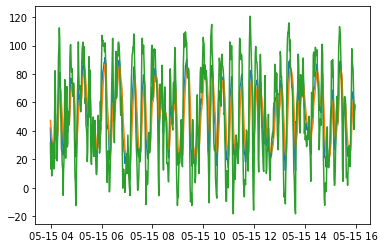

In [11]:
for symbol in symbols.keys():
    print(symbols[symbol].KDJ)
    plt.plot(symbols[symbol].KDJ)
    plt.show()

                             MACD   signal_line     histogram
time                                                         
2020-05-15 03:58:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-05-15 03:59:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-05-15 04:00:00  5.581789e-09  2.287619e-09  3.294171e-09
2020-05-15 04:01:00  9.427886e-09  4.706408e-09  4.721477e-09
2020-05-15 04:02:00  1.052347e-08  6.436853e-09  4.086618e-09
...                           ...           ...           ...
2020-05-15 15:53:00 -8.891876e-08 -1.128414e-07  2.392263e-08
2020-05-15 15:54:00 -7.543612e-08 -1.053603e-07  2.992422e-08
2020-05-15 15:55:00 -6.241768e-08 -9.677180e-08  3.435413e-08
2020-05-15 15:56:00 -4.592269e-08 -8.660198e-08  4.067929e-08
2020-05-15 15:57:00 -3.646453e-08 -7.657449e-08  4.010996e-08

[720 rows x 3 columns]


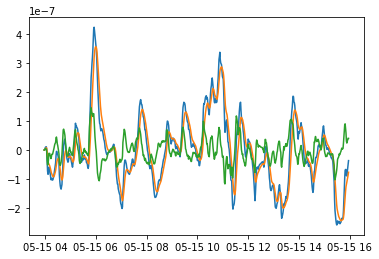

                         MACD  signal_line  histogram
time                                                 
2020-05-15 03:58:00  0.000000     0.000000   0.000000
2020-05-15 03:59:00  0.000000     0.000000   0.000000
2020-05-15 04:00:00  0.000000     0.000000   0.000000
2020-05-15 04:01:00  0.000029     0.000010   0.000019
2020-05-15 04:02:00  0.000004     0.000008  -0.000004
...                       ...          ...        ...
2020-05-15 15:53:00 -0.001752    -0.001868   0.000117
2020-05-15 15:54:00 -0.001688    -0.001832   0.000144
2020-05-15 15:55:00 -0.001595    -0.001785   0.000190
2020-05-15 15:56:00 -0.001512    -0.001730   0.000218
2020-05-15 15:57:00 -0.001397    -0.001664   0.000266

[720 rows x 3 columns]


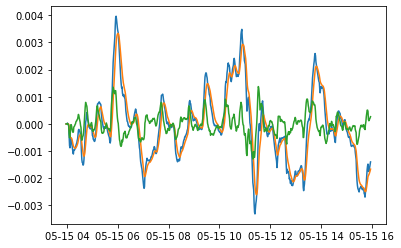

                          MACD  signal_line  histogram
time                                                  
2020-05-15 03:59:00   0.000000     0.000000   0.000000
2020-05-15 04:00:00  -0.547436    -0.304131  -0.243305
2020-05-15 04:01:00  -0.355812    -0.325312  -0.030500
2020-05-15 04:02:00  -1.484607    -0.718027  -0.766580
2020-05-15 04:03:00  -1.474613    -0.943094  -0.531519
...                        ...          ...        ...
2020-05-15 15:54:00 -20.331439   -19.215103  -1.116335
2020-05-15 15:55:00 -20.867412   -19.545565  -1.321847
2020-05-15 15:56:00 -21.934201   -20.023292  -1.910909
2020-05-15 15:57:00 -20.366196   -20.091873  -0.274323
2020-05-15 15:58:00 -18.549825   -19.783463   1.233638

[720 rows x 3 columns]


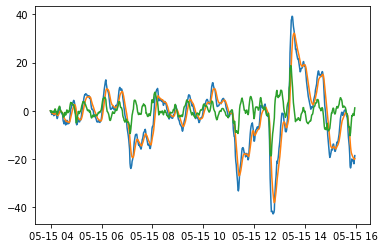

In [12]:
for symbol in symbols.keys():
    print(symbols[symbol].MACD)
    plt.plot(symbols[symbol].MACD)
    plt.show()

                         open      high       low     close   volume  \
time                                                                   
2020-05-15 04:36:00  0.000041  0.000041  0.000040  0.000041  31506.0   
2020-05-15 04:37:00  0.000041  0.000041  0.000041  0.000041  11059.0   
2020-05-15 04:38:00  0.000041  0.000041  0.000041  0.000041  29378.0   
2020-05-15 04:39:00  0.000041  0.000041  0.000041  0.000041  28704.0   
2020-05-15 04:40:00  0.000041  0.000041  0.000041  0.000041  17197.0   
...                       ...       ...       ...       ...      ...   
2020-05-15 15:53:00  0.000041  0.000041  0.000041  0.000041  12134.0   
2020-05-15 15:54:00  0.000041  0.000041  0.000041  0.000041  33416.0   
2020-05-15 15:55:00  0.000041  0.000041  0.000041  0.000041   6106.0   
2020-05-15 15:56:00  0.000041  0.000041  0.000041  0.000041  24331.0   
2020-05-15 15:57:00  0.000041  0.000041  0.000041  0.000041  34441.0   

                             K          D          J        MA 

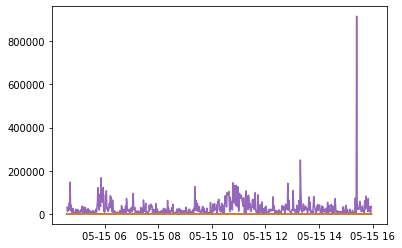

                       open    high     low   close    volume          K  \
time                                                                       
2020-05-15 04:36:00  0.3872  0.3880  0.3861  0.3878  77933.14  16.602234   
2020-05-15 04:37:00  0.3879  0.3891  0.3873  0.3886  10008.08  25.295798   
2020-05-15 04:38:00  0.3883  0.3885  0.3870  0.3874  42477.50  27.086088   
2020-05-15 04:39:00  0.3879  0.3890  0.3872  0.3885  16335.42  33.372707   
2020-05-15 04:40:00  0.3885  0.3900  0.3885  0.3900  45646.50  46.268079   
...                     ...     ...     ...     ...       ...        ...   
2020-05-15 15:53:00  0.3796  0.3808  0.3795  0.3808  13508.75  41.044973   
2020-05-15 15:54:00  0.3808  0.3822  0.3808  0.3815  19678.65  42.009780   
2020-05-15 15:55:00  0.3820  0.3823  0.3817  0.3818   4363.10  44.168136   
2020-05-15 15:56:00  0.3822  0.3826  0.3817  0.3817   8034.83  45.101990   
2020-05-15 15:57:00  0.3822  0.3829  0.3811  0.3821  60708.25  47.744761   

           

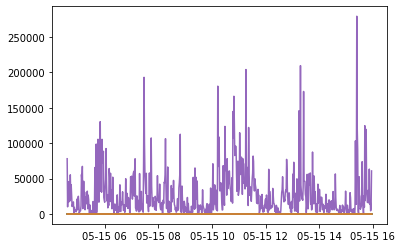

                        open     high      low    close      volume  \
time                                                                  
2020-05-15 04:37:00  9540.05  9560.00  9540.05  9548.71   55.495480   
2020-05-15 04:38:00  9547.26  9550.59  9543.22  9546.54   37.025678   
2020-05-15 04:39:00  9545.09  9546.43  9523.55  9526.40   79.018663   
2020-05-15 04:40:00  9526.40  9529.02  9510.00  9529.02  217.859994   
2020-05-15 04:41:00  9528.42  9545.99  9519.29  9542.35   89.905320   
...                      ...      ...      ...      ...         ...   
2020-05-15 15:54:00  9295.05  9297.95  9288.73  9293.84   15.462854   
2020-05-15 15:55:00  9294.25  9300.00  9280.51  9281.53   77.482287   
2020-05-15 15:56:00  9281.52  9281.52  9267.11  9270.44   63.917749   
2020-05-15 15:57:00  9270.02  9300.00  9268.72  9297.44   48.405406   
2020-05-15 15:58:00  9298.52  9302.00  9295.86  9301.90   16.053698   

                             K          D          J         MA        BB_up

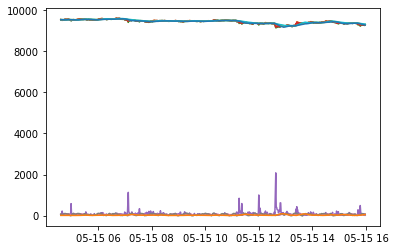

In [13]:
for symbol in symbols.keys():
    print(symbols[symbol].bollinger_bands)
    plt.plot(symbols[symbol].bollinger_bands)
    plt.show()

In [ ]:
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()

scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(15)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol

best_assets:  ['BTC']
best_assets:  ['BTC']
best_assets:  ['BTC']
best_assets:  ['BTC']


In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()